In [1]:
!pip install -q yfinance scikit-learn seaborn pandas_ta --upgrade



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [4]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import TimeSeriesSplit
import datetime

# ── Helper: flatten multi‑level columns (just in case) ────────────
def flatten_columns(df):
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [
            "_".join([str(x) for x in tup if str(x) != ""]).rstrip("_")
            for tup in df.columns.values
        ]
    return df


In [5]:
DATA_PATH = "/content/labeled_financial_news_2M_clean.csv"   # adjust if needed

df = pd.read_csv(DATA_PATH)

# ➊ Parse to datetime
df["date"] = pd.to_datetime(df["date"], utc=True)

# ➋ Drop tz info → tz‑naïve & normalise to midnight (avoid hh:mm:ss mismatches)
df["date"] = df["date"].dt.tz_localize(None).dt.normalize()

# ➌ Map sentiment → numeric score
sentiment_map = {"bullish": 1, "neutral": 0, "bearish": -1}
df["sent_score"] = df["sentiment"].map(sentiment_map)

# ➍ Daily aggregates
daily_sent = (
    df.groupby("date")
      .agg(mean_score   = ("sent_score",  "mean"),
           bullish_pct  = ("sentiment",   lambda x: (x == "bullish").mean()),
           bearish_pct  = ("sentiment",   lambda x: (x == "bearish").mean()),
           n_articles   = ("sentiment",   "size"))
      .reset_index()
)

print("Daily sentiment sample\n", daily_sent.head())


Daily sentiment sample
         date  mean_score  bullish_pct  bearish_pct  n_articles
0 2009-02-14         0.0          0.0          0.0           1
1 2009-04-27         0.0          0.0          0.0           2
2 2009-04-29         0.0          0.0          0.0           1
3 2009-05-22         0.0          0.0          0.0           1
4 2009-05-27         0.5          0.5          0.0           6


In [6]:
# ── 4️⃣  Download & prepare S&P 500 prices ─────────────────────────
sp = yf.download(
        "^GSPC",
        start=daily_sent["date"].min(),
        end=datetime.date.today(),
        auto_adjust=False,     # <-- keep the raw 'Close' column
        progress=False
     )

# ➊  Peek at the columns to confirm what we got
print("Columns returned by yfinance:", sp.columns.tolist())

# ➋  Flatten MultiIndex columns if needed
sp = flatten_columns(sp)

# ➌  Identify the close‑price column robustly
close_col_candidates = [c for c in sp.columns if c.lower().startswith("close")]
if not close_col_candidates:
    raise ValueError("Could not find a Close price column in the yfinance data!")
close_col = close_col_candidates[0]   # pick the first match

# ➍  Keep only that column and standardise its name
sp = sp[[close_col]].rename(columns={close_col: "sp_close"})

# ➎  Ensure index is tz‑naïve & normalised to midnight
sp.index = pd.to_datetime(sp.index).tz_localize(None).normalize()

# ➏  Reset index → plain 'date' column
sp_reset = (
    sp.reset_index()
      .rename(columns={"index": "date", "Date": "date"})   # handle either label
)

print("S&P‑500 sample\n", sp_reset.head())


Columns returned by yfinance: [('Adj Close', '^GSPC'), ('Close', '^GSPC'), ('High', '^GSPC'), ('Low', '^GSPC'), ('Open', '^GSPC'), ('Volume', '^GSPC')]
S&P‑500 sample
         date    sp_close
0 2009-02-17  789.169983
1 2009-02-18  788.419983
2 2009-02-19  778.940002
3 2009-02-20  770.049988
4 2009-02-23  743.330017


In [7]:
merged = pd.merge(daily_sent, sp_reset, on="date", how="inner")

# Next‑day return & binary target
merged["next_close"] = merged["sp_close"].shift(-1)
merged["next_ret"]   = merged["next_close"] / merged["sp_close"] - 1
merged["target_up"]  = (merged["next_ret"] > 0).astype(int)

merged = merged.dropna()          # final row after shift
print("Merged data\n", merged.head())


Merged data
         date  mean_score  bullish_pct  bearish_pct  n_articles    sp_close  \
0 2009-04-27         0.0          0.0          0.0           2  857.510010   
1 2009-04-29         0.0          0.0          0.0           1  873.640015   
2 2009-05-22         0.0          0.0          0.0           1  887.000000   
3 2009-05-27         0.5          0.5          0.0           6  893.059998   
4 2009-05-29         0.0          0.0          0.0           2  919.140015   

   next_close  next_ret  target_up  
0  873.640015  0.018810          1  
1  887.000000  0.015292          1  
2  893.059998  0.006832          1  
3  919.140015  0.029203          1  
4  942.869995  0.025818          1  


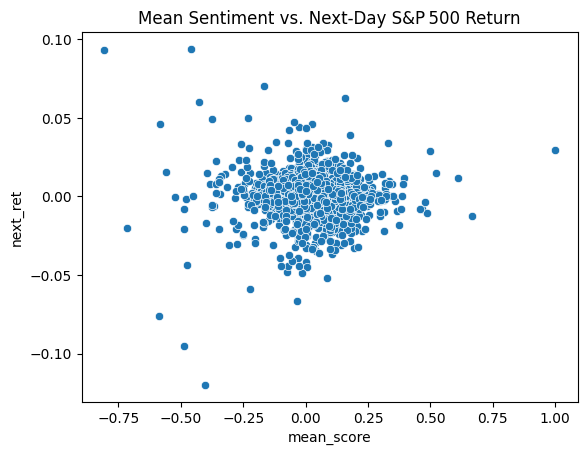

Correlation: 0.005523991940985649


In [8]:
sns.scatterplot(data=merged, x="mean_score", y="next_ret")
plt.title("Mean Sentiment vs. Next‑Day S&P 500 Return")
plt.show()

print("Correlation:", merged["mean_score"].corr(merged["next_ret"]))


In [9]:
features = ["mean_score", "bullish_pct", "bearish_pct", "n_articles"]
X = merged[features].values
y = merged["target_up"].values

tscv = TimeSeriesSplit(n_splits=5)
acc, auc = [], []

for train_idx, test_idx in tscv.split(X):
    model = LogisticRegression(max_iter=1000)
    model.fit(X[train_idx], y[train_idx])

    y_pred = model.predict(X[test_idx])
    y_prob = model.predict_proba(X[test_idx])[:, 1]

    acc.append(accuracy_score(y[test_idx], y_pred))
    auc.append(roc_auc_score(y[test_idx], y_prob))

print(f"Accuracy: {np.mean(acc):.3f} ± {np.std(acc):.3f}")
print(f"AUC:      {np.mean(auc):.3f} ± {np.std(auc):.3f}")


Accuracy: 0.543 ± 0.027
AUC:      0.492 ± 0.025
